In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oprec-ristek-dsa-2023/sample_submission.csv
/kaggle/input/oprec-ristek-dsa-2023/rank_prodi.csv
/kaggle/input/oprec-ristek-dsa-2023/skor_saintek.csv
/kaggle/input/oprec-ristek-dsa-2023/train.csv
/kaggle/input/oprec-ristek-dsa-2023/test.csv
/kaggle/input/oprec-ristek-dsa-2023/universitas.csv


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import catboost

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_test = pd.read_csv('/kaggle/input/oprec-ristek-dsa-2023/test.csv')
df_train = pd.read_csv('/kaggle/input/oprec-ristek-dsa-2023/train.csv')
rank_prodi = pd.read_csv('/kaggle/input/oprec-ristek-dsa-2023/rank_prodi.csv')
universitas = pd.read_csv('/kaggle/input/oprec-ristek-dsa-2023/universitas.csv')
skor_saintek = pd.read_csv('/kaggle/input/oprec-ristek-dsa-2023/skor_saintek.csv')

# Exploratory Data Analysis

**df_train**

In [4]:
df_train.head()

,id_prodi,avg_nilai_lolos,std_nilai_lolos,passing_grade,nilai_tertinggi
0,3511096,627.90,12.42,612.49,664.31
1,3621037,627.85,13.07,615.04,668.78
2,3321096,710.29,24.81,676.94,785.42
3,3721031,648.08,17.38,626.10,695.92
4,3331021,652.67,19.21,626.86,702.93


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_prodi         300 non-null    int64  
 1   avg_nilai_lolos  300 non-null    float64
 2   std_nilai_lolos  300 non-null    float64
 3   passing_grade    300 non-null    float64
 4   nilai_tertinggi  300 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.8 KB


In [6]:
df_train.describe()

,id_prodi,avg_nilai_lolos,std_nilai_lolos,passing_grade,nilai_tertinggi
count,3.000000e+02,300.000000,300.000000,300.000000,300.000000
mean,3.516195e+06,635.241733,16.096867,616.596867,685.847400
std,1.017163e+06,27.569290,3.974614,25.448249,37.762974
min,1.111165e+06,595.670000,8.690000,581.920000,622.130000
25%,3.331019e+06,612.850000,13.052500,594.847500,656.035000
50%,3.551024e+06,629.850000,15.805000,613.790000,680.370000
75%,3.721106e+06,652.452500,18.105000,632.682500,709.365000
max,9.111126e+06,747.930000,29.350000,724.380000,798.550000


visualisasi persebaran dan hubungan tiap fitur data train dengan passing_grade

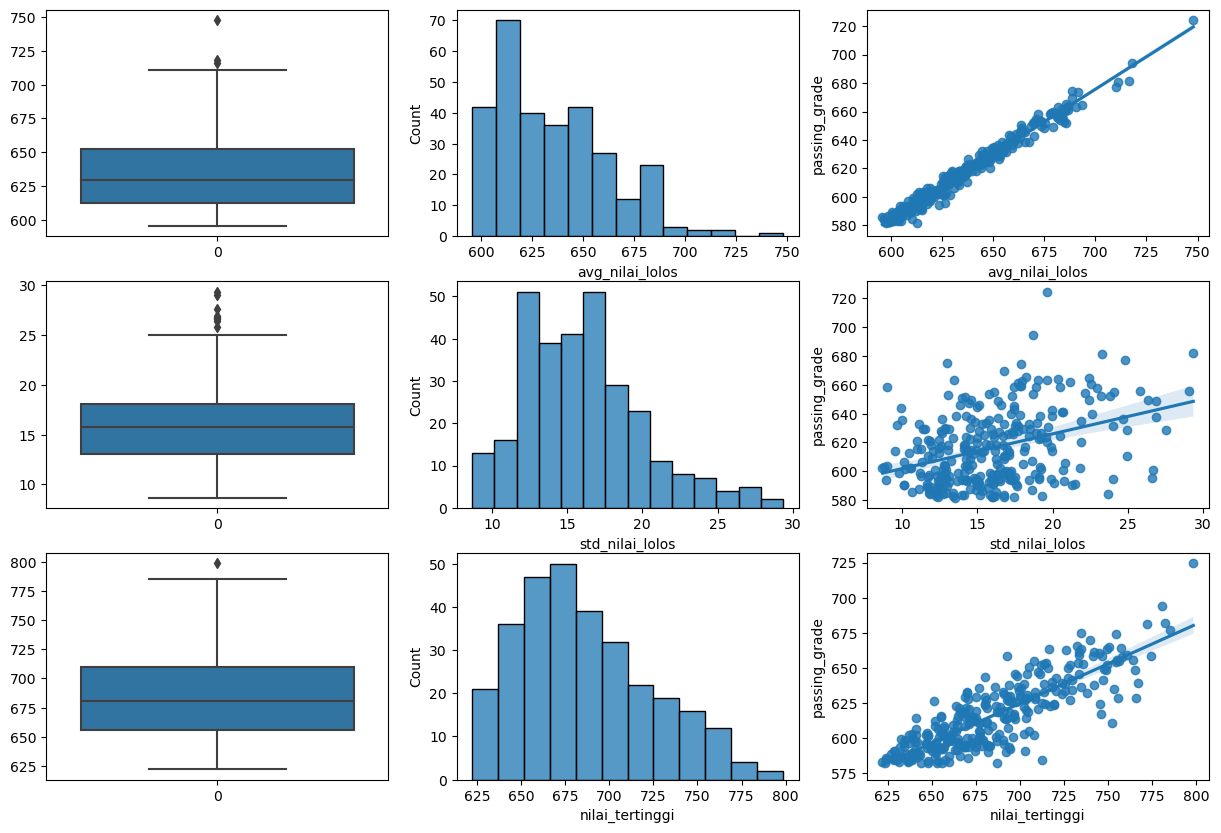

In [7]:
cols = [col for col in df_train.columns if 'nilai' in col]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
for i in range(3):
    sns.boxplot(df_train[cols[i]], ax=axs[i,0])
    sns.histplot(df_train[cols[i]], ax=axs[i,1])
    sns.regplot(x=cols[i], y='passing_grade', data=df_train, ax=axs[i,2])
plt.show()

**rank_prodi**

In [8]:
rank_prodi.head()

,rank,id_prodi,prodi-universitas,id_universitas,wilayah,peminat_2017,kapasitas_2018,peminat_2018,kapasitas_2019
0,1.0,3211015,Pendidikan Dokter - UI,321,1,4041.0,127.0,3955.0,72
1,2.0,3321073,Sekolah Tek. Elektro & Informatika (STEI) - ITB,332,1,4215.0,168.0,4804.0,168
2,3.0,3321026,Fak. Teknik Pertamb. & Perminyakan (FTTM) - ITB,332,1,2889.0,132.0,2928.0,136
3,4.0,3321081,Fakultas Teknologi Industri (FTI) - Kampus Gan...,332,1,2034.0,142.0,2365.0,144
4,5.0,3611066,Kedokteran - UGM,361,2,3777.0,70.0,4444.0,79


In [9]:
rank_prodi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701 entries, 0 to 1700
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rank               1651 non-null   float64
 1   id_prodi           1701 non-null   int64  
 2   prodi-universitas  1701 non-null   object 
 3   id_universitas     1701 non-null   int64  
 4   wilayah            1701 non-null   int64  
 5   peminat_2017       1651 non-null   float64
 6   kapasitas_2018     1651 non-null   float64
 7   peminat_2018       1651 non-null   float64
 8   kapasitas_2019     1701 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 119.7+ KB


In [10]:
rank_prodi.describe()

,rank,id_prodi,id_universitas,wilayah,peminat_2017,kapasitas_2018,peminat_2018,kapasitas_2019
count,1651.000000,1.701000e+03,1701.000000,1701.000000,1651.000000,1651.000000,1651.000000,1701.000000
mean,826.000000,4.242945e+06,424.178718,2.288066,685.703816,48.981829,743.713507,47.613169
std,476.746963,2.284096e+06,228.408756,1.199227,712.281780,33.463951,766.269421,29.018630
min,1.000000,1.111014e+06,111.000000,1.000000,0.000000,7.000000,0.000000,6.000000
25%,413.500000,3.111076e+06,311.000000,1.000000,169.000000,28.000000,202.000000,30.000000
50%,826.000000,3.631055e+06,363.000000,2.000000,467.000000,41.000000,515.000000,40.000000
75%,1238.500000,6.121183e+06,612.000000,3.000000,987.500000,60.000000,1026.500000,60.000000
max,1651.000000,9.211352e+06,921.000000,4.000000,5979.000000,361.000000,6513.000000,312.000000


* prodi yang tidak memiliki rank akan dianggap sebagai rank terakhir semua, yaitu rank 1652
* untuk kolom peminat_2017, kapasitas_2018, dan peminat_2018 nilainya akan diset menjadi 0

In [11]:
idx = rank_prodi.loc[rank_prodi['peminat_2017'].isna(), :].index
rank_prodi.loc[rank_prodi['peminat_2017'].isna(), 'rank'] = idx
for i in idx:
    rank_prodi.loc[i, ['peminat_2017', 'kapasitas_2018', 'peminat_2018']] = 0
    rank_prodi.loc[i, 'rank'] = 1652
rank_prodi = rank_prodi.drop('prodi-universitas', axis=1)

visualisasi persebaran data dan korelasi antara kapasitas dan peminat dengan passing grade

In [12]:
dummy2 = df_train.merge(rank_prodi, on='id_prodi', how='left')
dummy2 = dummy2.drop(['avg_nilai_lolos', 'std_nilai_lolos', 'nilai_tertinggi', 'id_universitas'], axis=1)

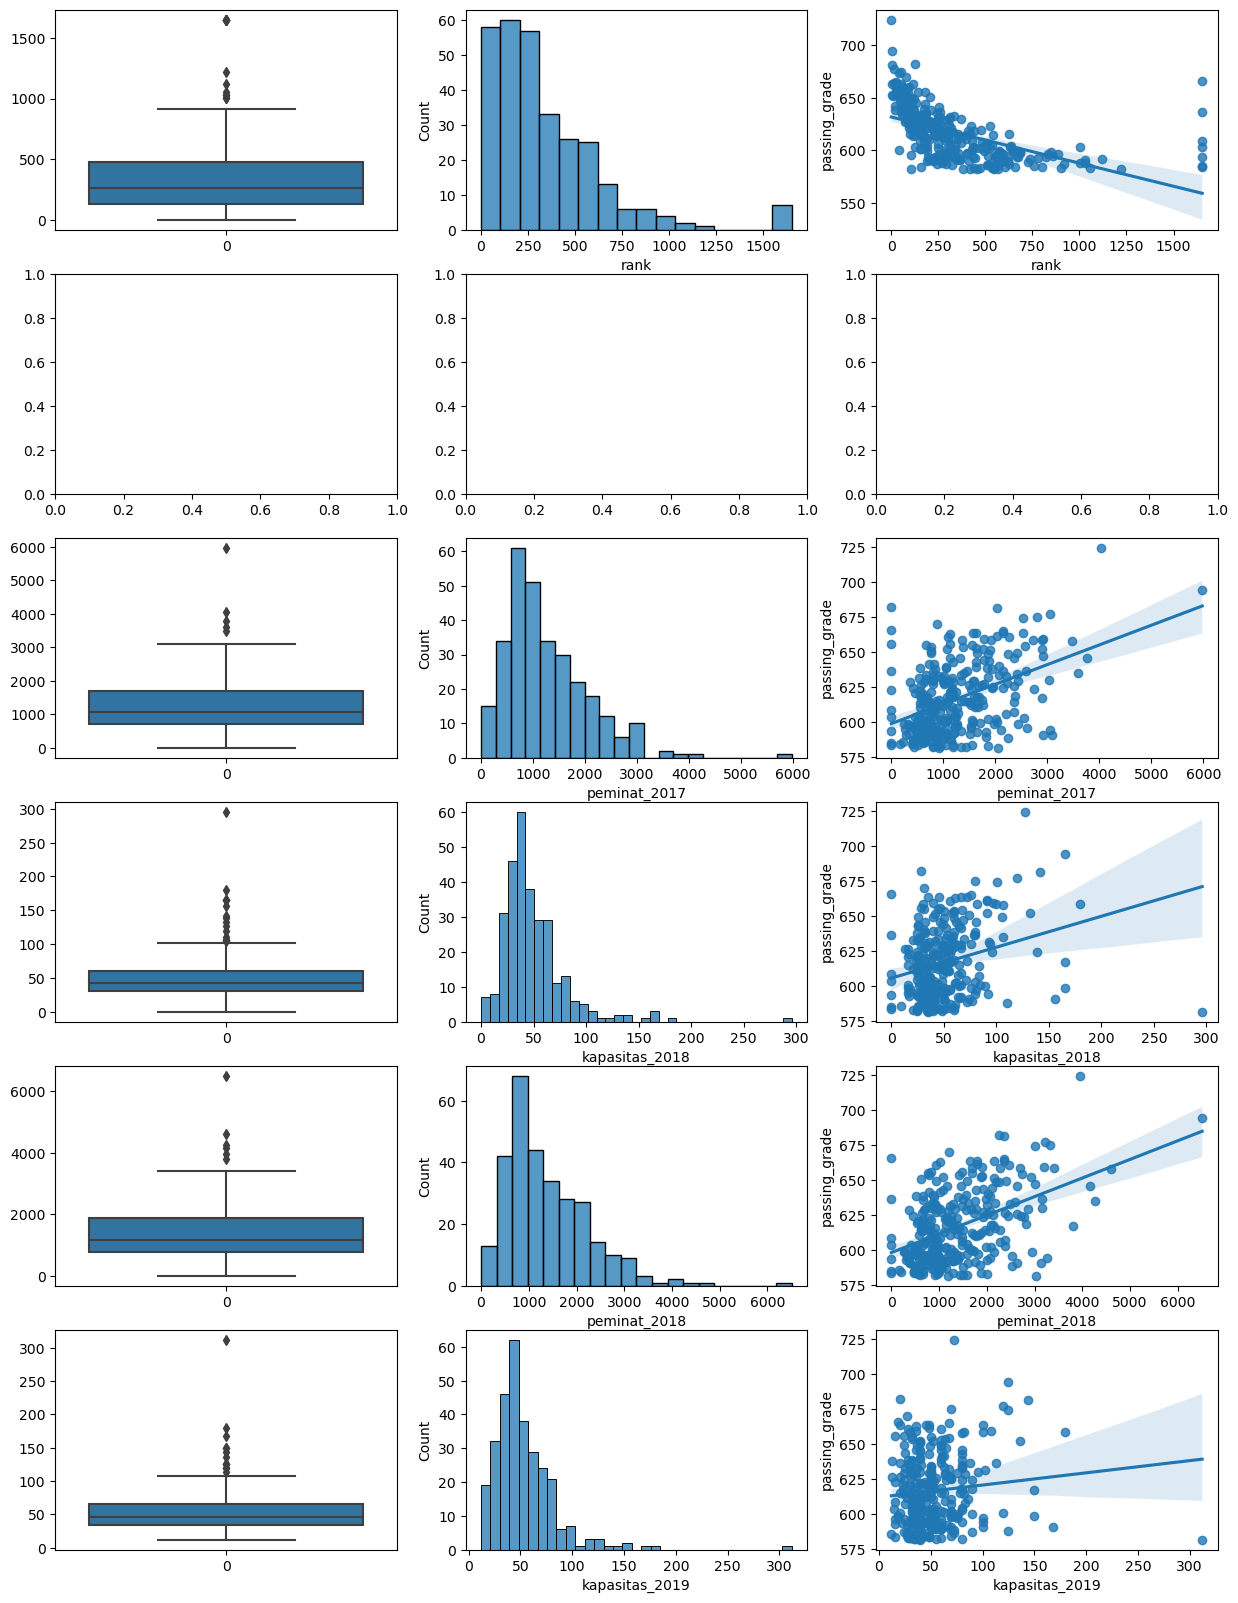

In [13]:
cols = [col for col in dummy2.columns if col != 'id_prodi' and col != 'passing_grade']

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(15,20))
for i in range(6):
    if cols[i] == 'wilayah':
        continue
    sns.boxplot(dummy2[cols[i]], ax=axs[i,0])
    sns.histplot(dummy2[cols[i]], ax=axs[i,1])
    sns.regplot(x=cols[i], y='passing_grade', data=dummy2, ax=axs[i,2])
plt.show()

**universitas**

In [14]:
universitas.head()

,id_universitas,nama_universitas
0,111,UNIVERSITAS SYIAH KUALA
1,112,UNIVERSITAS MALIKUSSALEH
2,113,UNIVERSITAS TEUKU UMAR
3,114,UNIVERSITAS SAMUDRA
4,115,ISBI ACEH


In [15]:
universitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_universitas    85 non-null     int64 
 1   nama_universitas  85 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


In [16]:
universitas.describe()

,id_universitas
count,85.000000
mean,411.411765
std,230.858145
min,111.000000
25%,192.000000
50%,361.000000
75%,611.000000
max,921.000000


**skor_saintek**

In [17]:
skor_saintek.head()

,id_prodi_pil1,id_universitas_pil1,id_prodi_pil2,id_universitas_pil2,id_siswa,skor_bio,skor_fis,skor_kim,skor_kmb,skor_kpu,skor_kua,skor_mat,skor_ppu
0,3321065,332,3331187,333,4,400,400,400,400,400,400,400,400
1,3211015,321,3611066,361,14,816,666,651,678,685,706,695,562
2,3721093,372,3551302,355,19,562,839,624,700,781,464,551,668
3,3321096,332,3551194,355,23,700,669,692,679,692,813,507,573
4,5211104,521,5211085,521,28,461,619,441,593,563,500,666,370


In [18]:
skor_saintek.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86570 entries, 0 to 86569
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   id_prodi_pil1        86570 non-null  int64
 1   id_universitas_pil1  86570 non-null  int64
 2   id_prodi_pil2        86570 non-null  int64
 3   id_universitas_pil2  86570 non-null  int64
 4   id_siswa             86570 non-null  int64
 5   skor_bio             86570 non-null  int64
 6   skor_fis             86570 non-null  int64
 7   skor_kim             86570 non-null  int64
 8   skor_kmb             86570 non-null  int64
 9   skor_kpu             86570 non-null  int64
 10  skor_kua             86570 non-null  int64
 11  skor_mat             86570 non-null  int64
 12  skor_ppu             86570 non-null  int64
dtypes: int64(13)
memory usage: 8.6 MB


In [19]:
skor_saintek.describe()

,id_prodi_pil1,id_universitas_pil1,id_prodi_pil2,id_universitas_pil2,id_siswa,skor_bio,skor_fis,skor_kim,skor_kmb,skor_kpu,skor_kua,skor_mat,skor_ppu
count,8.657000e+04,86570.000000,8.657000e+04,86570.000000,86570.000000,86570.000000,86570.000000,86570.000000,86570.000000,86570.000000,86570.000000,86570.000000,86570.000000
mean,3.510065e+06,350.987317,3.482497e+06,348.189199,177509.875523,537.140522,539.335312,544.598036,565.798094,569.942879,569.147141,529.489303,544.597158
std,1.192799e+06,119.206515,1.258767e+06,125.840155,95418.883782,96.596624,102.293095,112.595368,95.166847,91.224084,111.385700,99.464651,87.436377
min,1.496000e+03,46.000000,1.025000e+03,33.000000,4.000000,245.000000,252.000000,213.000000,198.000000,193.000000,266.000000,219.000000,219.000000
25%,3.311094e+06,331.000000,3.241092e+06,324.000000,96827.250000,471.000000,468.000000,465.000000,500.000000,508.000000,489.000000,463.000000,487.000000
50%,3.531313e+06,353.000000,3.531321e+06,355.000000,183176.500000,531.000000,531.000000,536.000000,565.000000,571.000000,563.000000,520.000000,547.000000
75%,3.721232e+06,372.000000,3.721263e+06,372.000000,257122.750000,597.000000,604.000000,616.000000,632.000000,633.000000,645.000000,586.000000,604.000000
max,9.211352e+06,921.000000,9.211352e+06,921.000000,344192.000000,1000.000000,1070.000000,1044.000000,908.000000,881.000000,922.000000,1123.000000,842.000000


visualisasi persebaran skor tiap subject

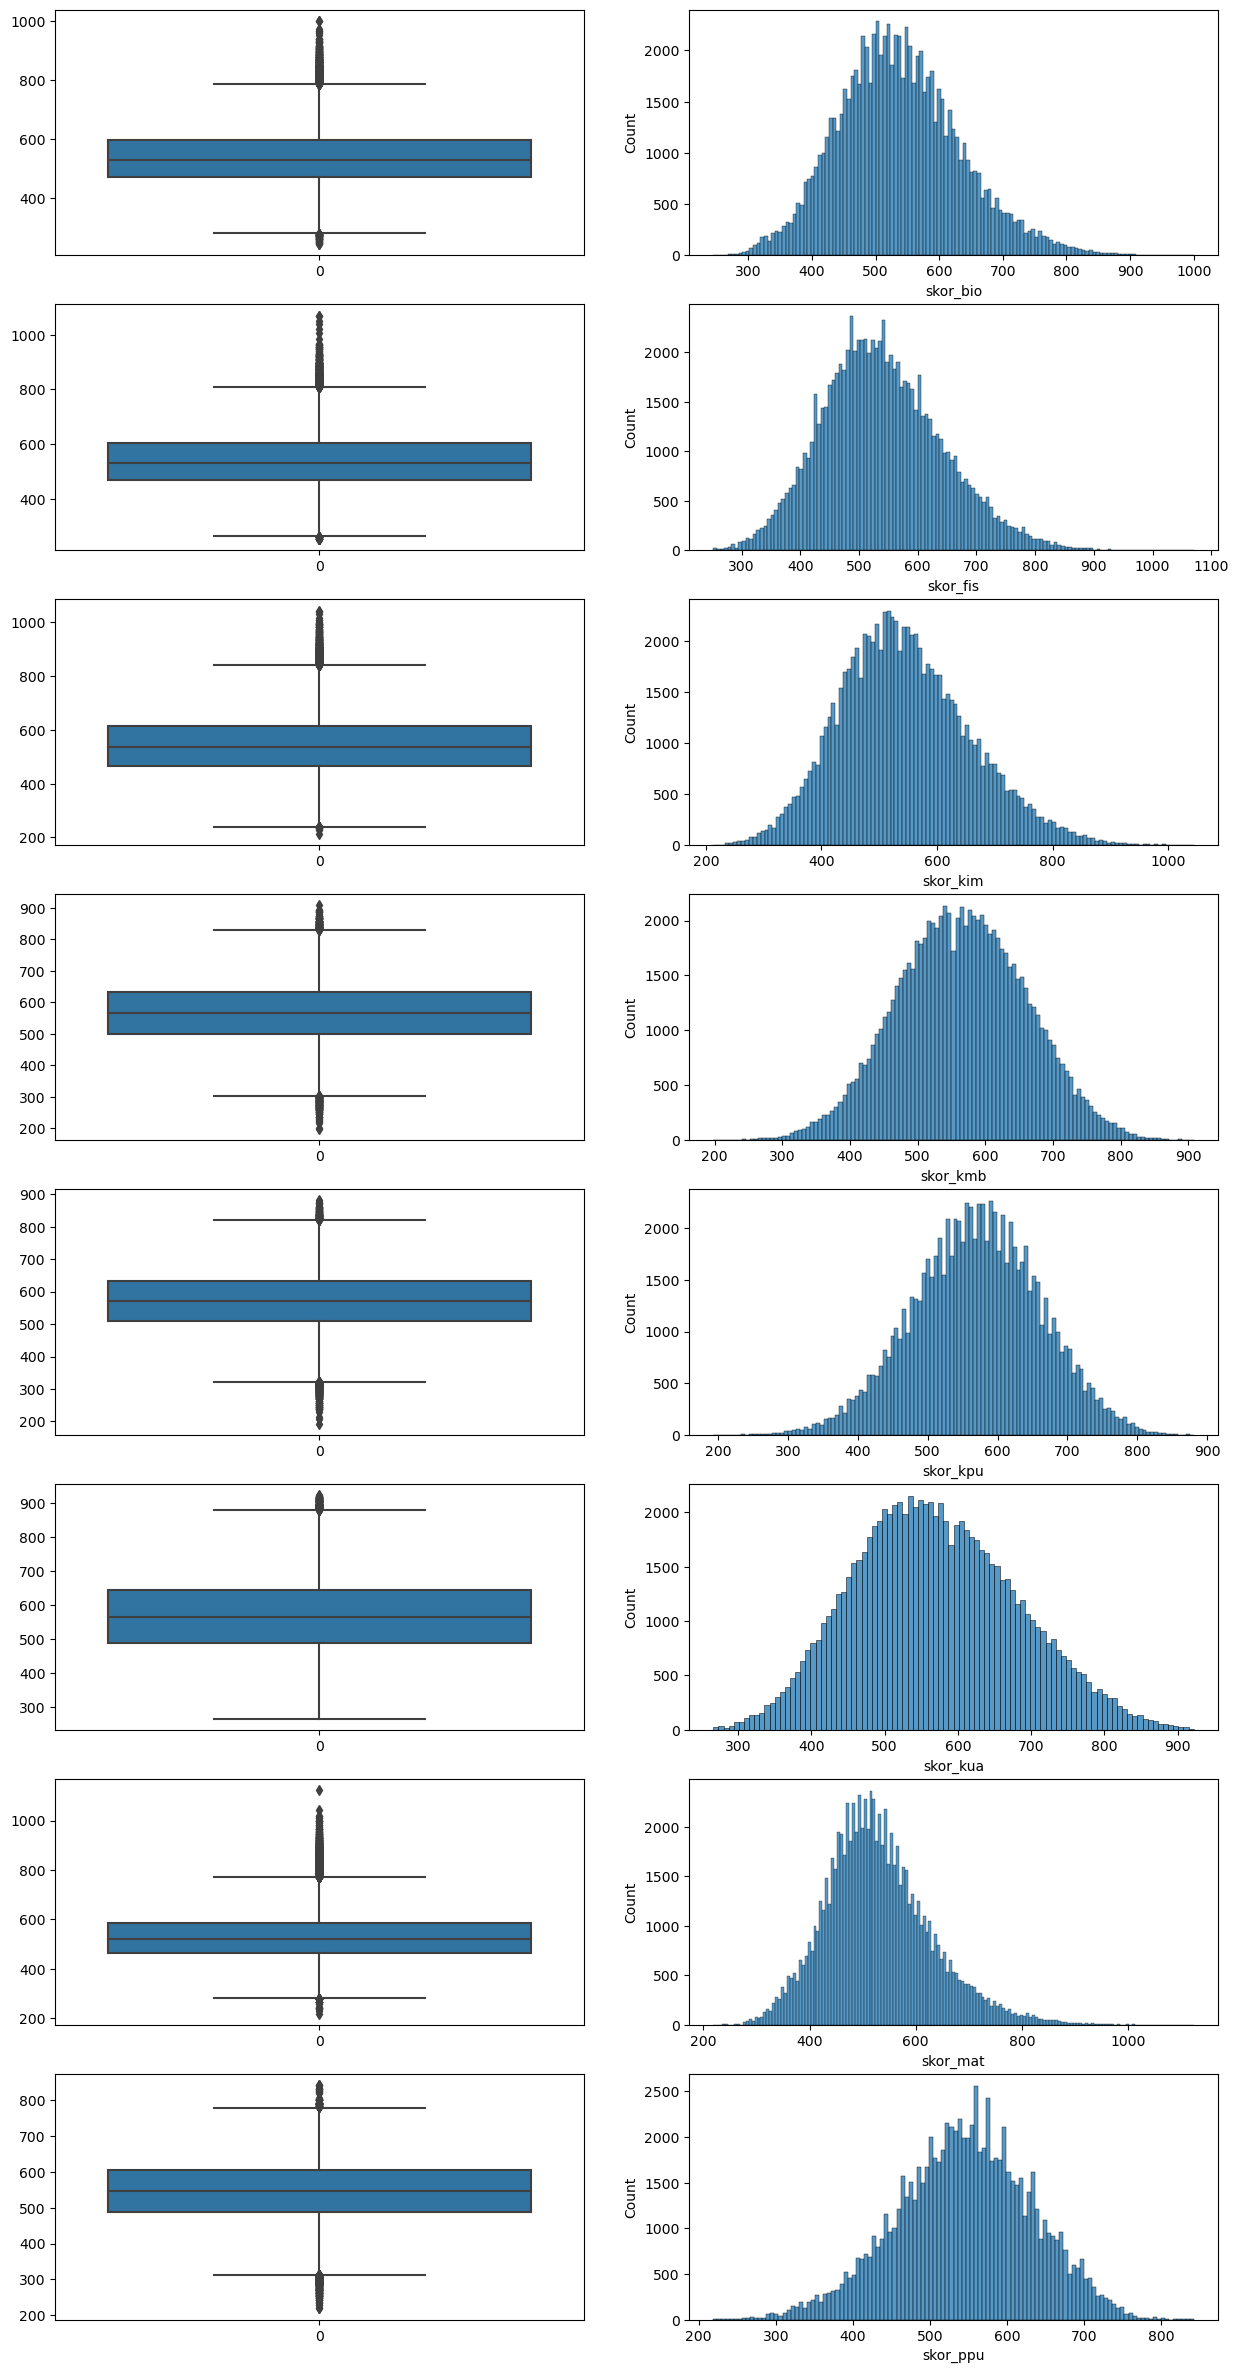

In [20]:
cols = [col for col in skor_saintek.columns if col.startswith('skor')]

fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(15,30))
for i in range(8):
    sns.boxplot(skor_saintek[cols[i]], ax=axs[i,0])
    sns.histplot(skor_saintek[cols[i]], ax=axs[i,1])
plt.show()

mendapatkan rata-rata skor setiap subject dari skor_saintek.csv berdasarkan id_prodi di train.csv

In [21]:
dummy = df_train[['id_prodi', 'passing_grade']].copy()
dummy[['skor_bio', 'skor_fis', 'skor_kim', 'skor_kmb', 'skor_kpu', 'skor_kua', 'skor_mat', 'skor_ppu']] = 0

for id_prodi in dummy['id_prodi']:
    for col in dummy.columns:
        if col.startswith('skor'):
            dummy.loc[dummy['id_prodi']==id_prodi, col] = skor_saintek.loc[skor_saintek['id_prodi_pil1']==id_prodi, col].mean()
dummy = dummy.dropna()

visualisasi nilai rata-rata tiap subject di prodi terkait dan korelasinya dengan passing_grade

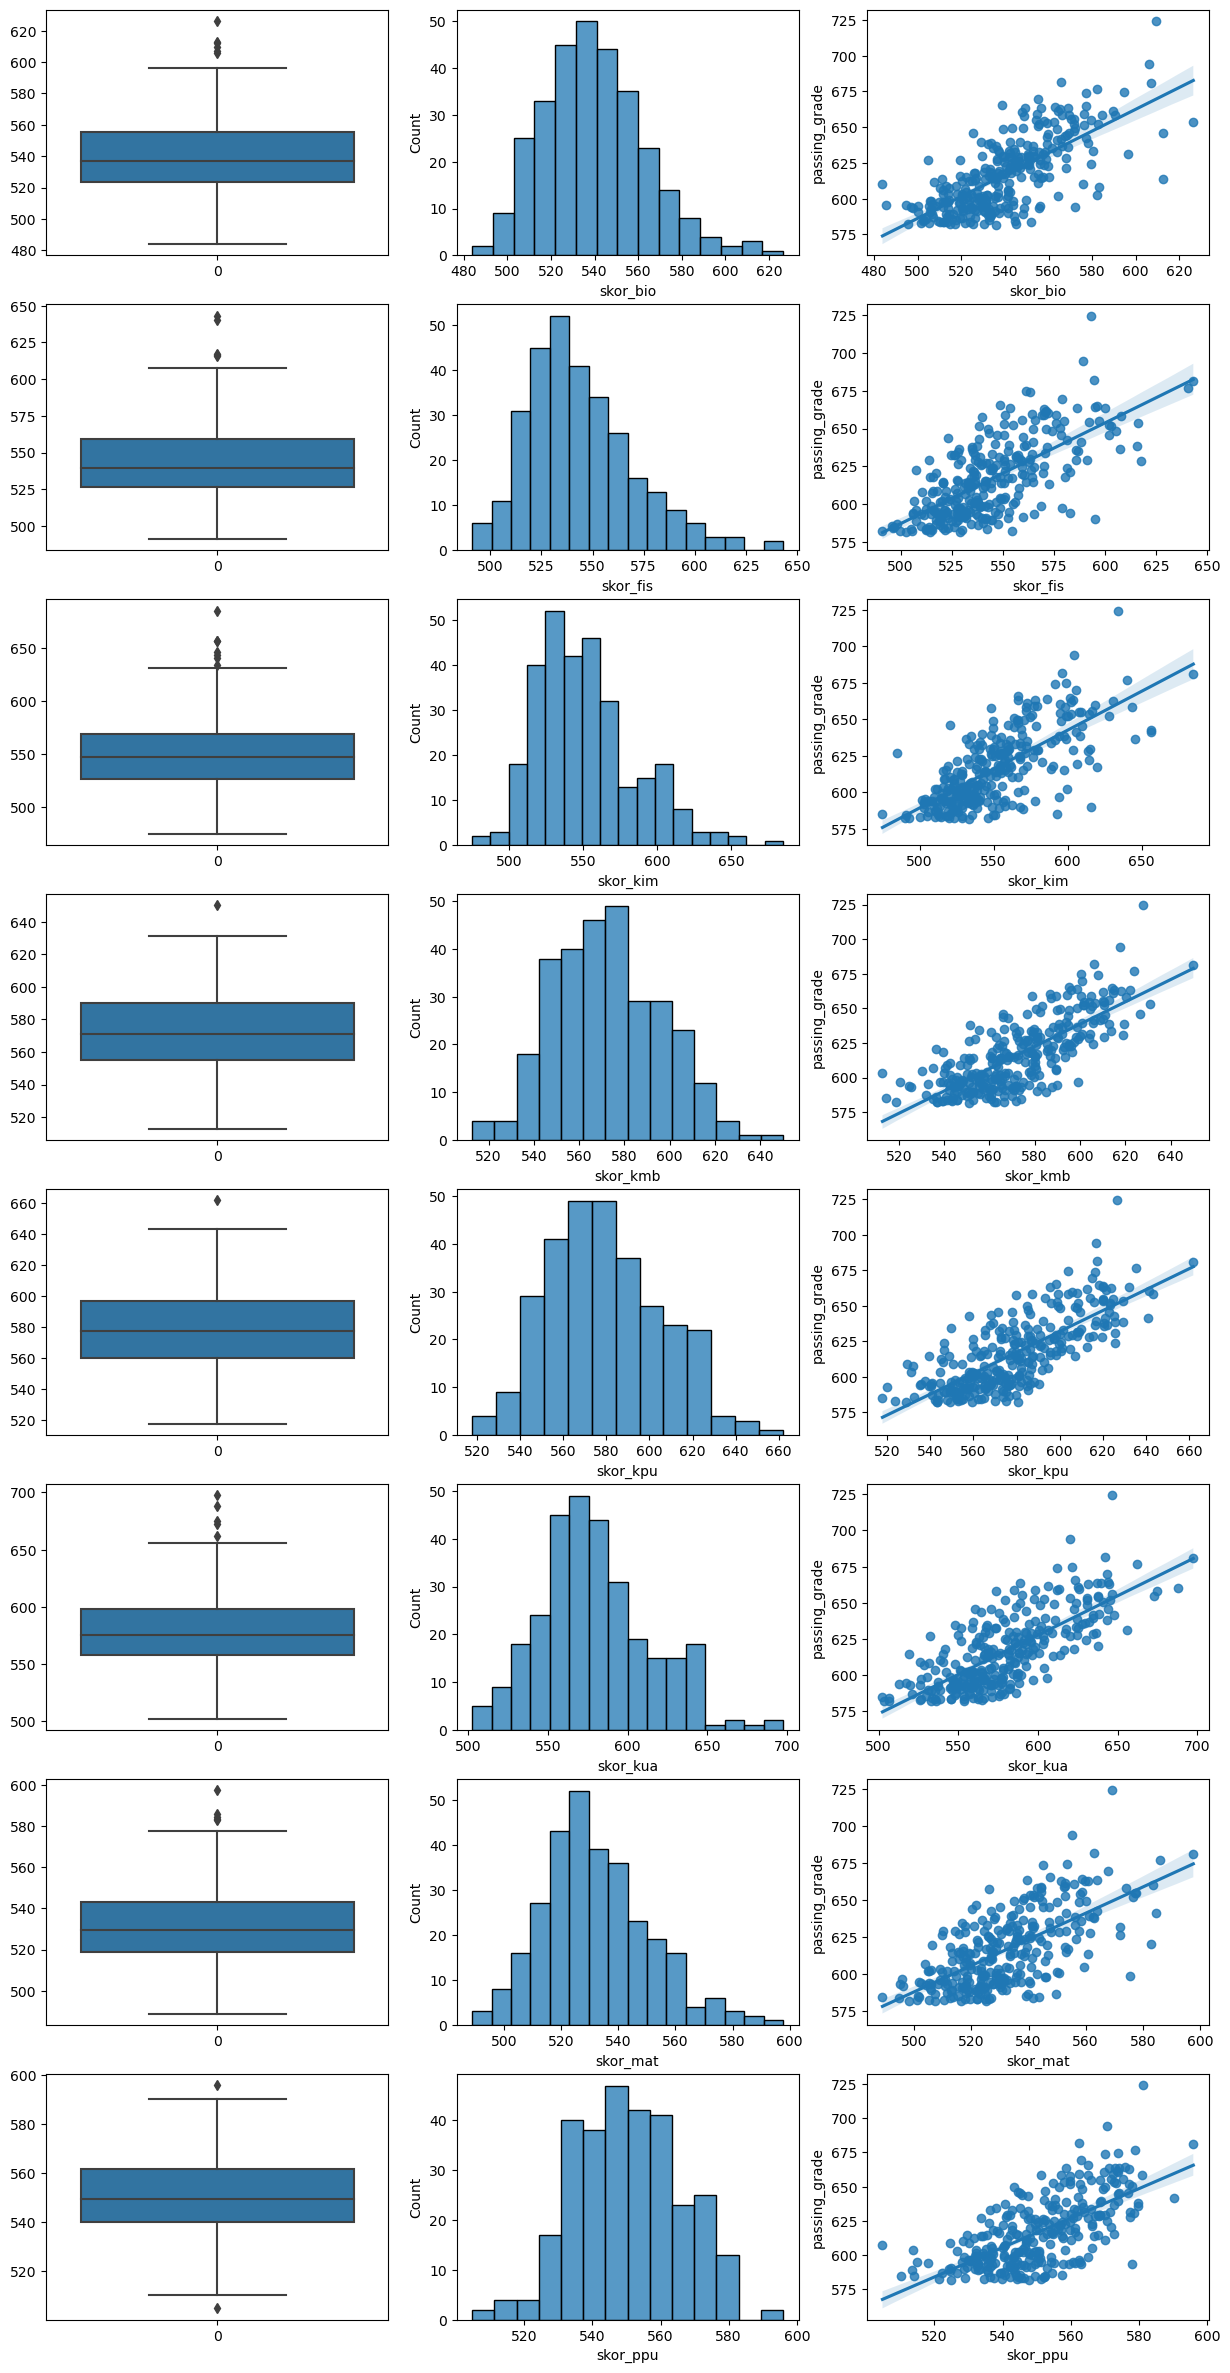

In [22]:
cols = [col for col in dummy.columns if col.startswith('skor')]

fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(15,30))
for i in range(8):
    sns.boxplot(dummy[cols[i]], ax=axs[i,0])
    sns.histplot(dummy[cols[i]], ax=axs[i,1])
    sns.regplot(x=cols[i], y='passing_grade', data=dummy, ax=axs[i,2])
plt.show()

In [23]:
df = skor_saintek.sort_values('id_prodi_pil1')

# menghapus baris dengan data tidak valid (jumlah digit id_prodi pilihan berbeda dengan yang lain)
df = df.drop(index=22169)
df = df.sort_index()
df = df.reset_index().set_index('index')

# Feature Engineering

In [24]:
rank = rank_prodi
rank = rank.rename(columns={'id_prodi':'id_prodi_pil1'})

In [25]:
# tes_df adalah hasil merge skor_saintek dengan rank berdasarkan id_prodi_pil1
tes_df = df.merge(rank, on='id_prodi_pil1', how='left')
tes_df.loc[tes_df['rank'].isna(), 'rank'] = 1652

tes_df = tes_df.rename(columns={'rank': 'rank_prodi_pil1'})
tes_df = tes_df.drop('id_universitas', axis=1)

tes_df = tes_df.rename(columns={'wilayah':'wilayah_pil1', 'peminat_2017':'peminat_2017_pil1', 'kapasitas_2018':'kapasitas_2018_pil1', 'peminat_2018':'peminat_2018_pil1', 'kapasitas_2019':'kapasitas_2019_pil1'})
tes_df = tes_df.drop(['id_universitas_pil1', 'id_universitas_pil2'], axis=1)

In [26]:
rank = rank.rename(columns={'id_prodi_pil1':'id_prodi_pil2'})

In [27]:
# tes_df2 adalah hasil merge tes_df dengan rank berdasarkan id_prodi_pil2
tes_df2 = tes_df.merge(rank, on='id_prodi_pil2', how='left')
tes_df2.loc[tes_df2['rank'].isna(), 'rank'] = 1652

tes_df2 = tes_df2.drop('id_universitas', axis=1)
tes_df2 = tes_df2.rename(columns={'rank':'rank_prodi_pil2','wilayah':'wilayah_pil2', 'peminat_2017':'peminat_2017_pil2', 'kapasitas_2018':'kapasitas_2018_pil2', 'peminat_2018':'peminat_2018_pil2', 'kapasitas_2019':'kapasitas_2019_pil2'})

dataframe score berisi skor siswa dan id prodi pilihannya

In [28]:
score = tes_df2.loc[:,['id_prodi_pil1', 'id_prodi_pil2', 'id_siswa', 'skor_bio', 'skor_fis','skor_kim', 'skor_kmb', 'skor_kpu', 'skor_kua', 'skor_mat', 'skor_ppu']]

membuat kolom baru all_score yang berisi rata-rata dari kedelapan skor pada skor_saintek

In [29]:
temp = 0
for col in score.columns:
    if col.startswith('skor'):
        temp += score[col]
temp /= 8
score['all_score'] = temp

membuat dataframe baru yang memiliki id_prodi dari rank_prodi dan jumlah pemilih di pilihan 1 dan di pilihan 2 berdasarkan data siswa di skor_saintek

In [30]:
jml_pil1 = pd.DataFrame({'id_prodi':score['id_prodi_pil1'].unique(), 'jml_pil1':score['id_prodi_pil1'].value_counts()})
jml_pil2 = pd.DataFrame({'id_prodi':score['id_prodi_pil2'].unique(), 'jml_pil2':score['id_prodi_pil2'].value_counts()})

In [31]:
rank = rank.rename(columns={'id_prodi_pil2':'id_prodi'})

In [32]:
# dummy_rank adalah hasil merge rank dan jml_pil1. ini akan berisi prodi dan jumlah siswa yang memilih prodi tsb di pilihan 1
dummy_rank = rank.copy()
dummy_rank = dummy_rank.merge(jml_pil1, on='id_prodi', how='left')

# merge lagi dengan jml_pil2. ini menambahkan kolom jumlah siswa yang memilih prodi tsb di pilihan 2
dummy_rank = dummy_rank.merge(jml_pil2, on='id_prodi', how='left')

# dummy_test hasil merge dari rank, jml_pil1, dan jml_pil2
dummy_test = df_test.merge(dummy_rank, on='id_prodi', how='left')
dummy_test.drop('id_universitas', axis=1, inplace=True)

In [33]:
# kapasitas berisi id_prodi pada rank dan kapasitasnya untuk 2019
kapasitas = rank[['id_prodi','kapasitas_2019']]
kapasitas = kapasitas.rename(columns={'id_prodi':'id_prodi_pil1'})

# merge score dengan kapasitas
score_lolos = score.merge(kapasitas, on='id_prodi_pil1', how='left')
score_lolos = score_lolos.rename(columns={'kapasitas_2019':'kapasitas_2019_pil1'})
score_lolos = score_lolos.dropna()

In [34]:
# menyimpan id_prodi dari data train dan data test
prodi_in_test = df_test['id_prodi']
prodi_in_train = df_train['id_prodi']

membuat kolom avg_nilai_lolos, std_nilai_lolos, nilai_tertinggi pada data test berdasarkan nilai siswa pada skor_saintek yang nilai rata-ratanya berada pada posisi n tertinggi (n adalah kapasitas prodi)

In [35]:
# new_score berisi avg, std, max untuk semua subject (jadi 1) score untuk ditaruh di data test
new_score = pd.DataFrame({'id_prodi':prodi_in_test, 'avg_score_lolos':0, 'std_score_lolos':0, 'max_score_lolos':0}, index=range(len(prodi_in_test)))

In [36]:
my_score = score_lolos.copy().sort_values('all_score', ascending=False)
for id_prodi in prodi_in_test:
    idx = my_score.loc[my_score['id_prodi_pil1'] == id_prodi, 'kapasitas_2019_pil1']
    kapasitas = int(np.array(idx)[0])
    new_score.loc[new_score['id_prodi']==id_prodi, 'avg_score_lolos'] = my_score.loc[(my_score['id_prodi_pil1']==id_prodi) | (my_score['id_prodi_pil2']==id_prodi), 'all_score'][:kapasitas].mean()
    new_score.loc[new_score['id_prodi']==id_prodi, 'std_score_lolos'] = my_score.loc[(my_score['id_prodi_pil1']==id_prodi) | (my_score['id_prodi_pil2']==id_prodi), 'all_score'][:kapasitas].std()
    new_score.loc[new_score['id_prodi']==id_prodi, 'max_score_lolos'] = my_score.loc[(my_score['id_prodi_pil1']==id_prodi) | (my_score['id_prodi_pil2']==id_prodi), 'all_score'][:kapasitas].max()

In [37]:
# kolom skor
skor_cols = ['skor_bio', 'skor_fis','skor_kim', 'skor_kmb', 'skor_kpu', 'skor_kua', 'skor_mat', 'skor_ppu']

In [38]:
# merge data test dengan new_score
df_test_fix = dummy_test.merge(new_score, on='id_prodi', how='left')

# rename column
df_test_fix = df_test_fix.rename(columns={'avg_score_lolos':'avg_nilai_lolos', 'std_score_lolos':'std_nilai_lolos', 'max_score_lolos':'nilai_tertinggi'})

In [39]:
# merge data train dengan rank, jml_pil1, dan jml_pil2
df_train_fix = df_train.merge(rank, on='id_prodi', how='left').drop('id_universitas', axis=1)
df_train_fix = df_train_fix.merge(jml_pil1, on='id_prodi', how='left')
df_train_fix = df_train_fix.merge(jml_pil2, on='id_prodi', how='left')
df_train_fix = df_train_fix.dropna()

visualisasi prodi berdasarkan jumlah pemilihnya di pilihan 1 maupun pilihan 2 dan korelasinya dengan passing_grade

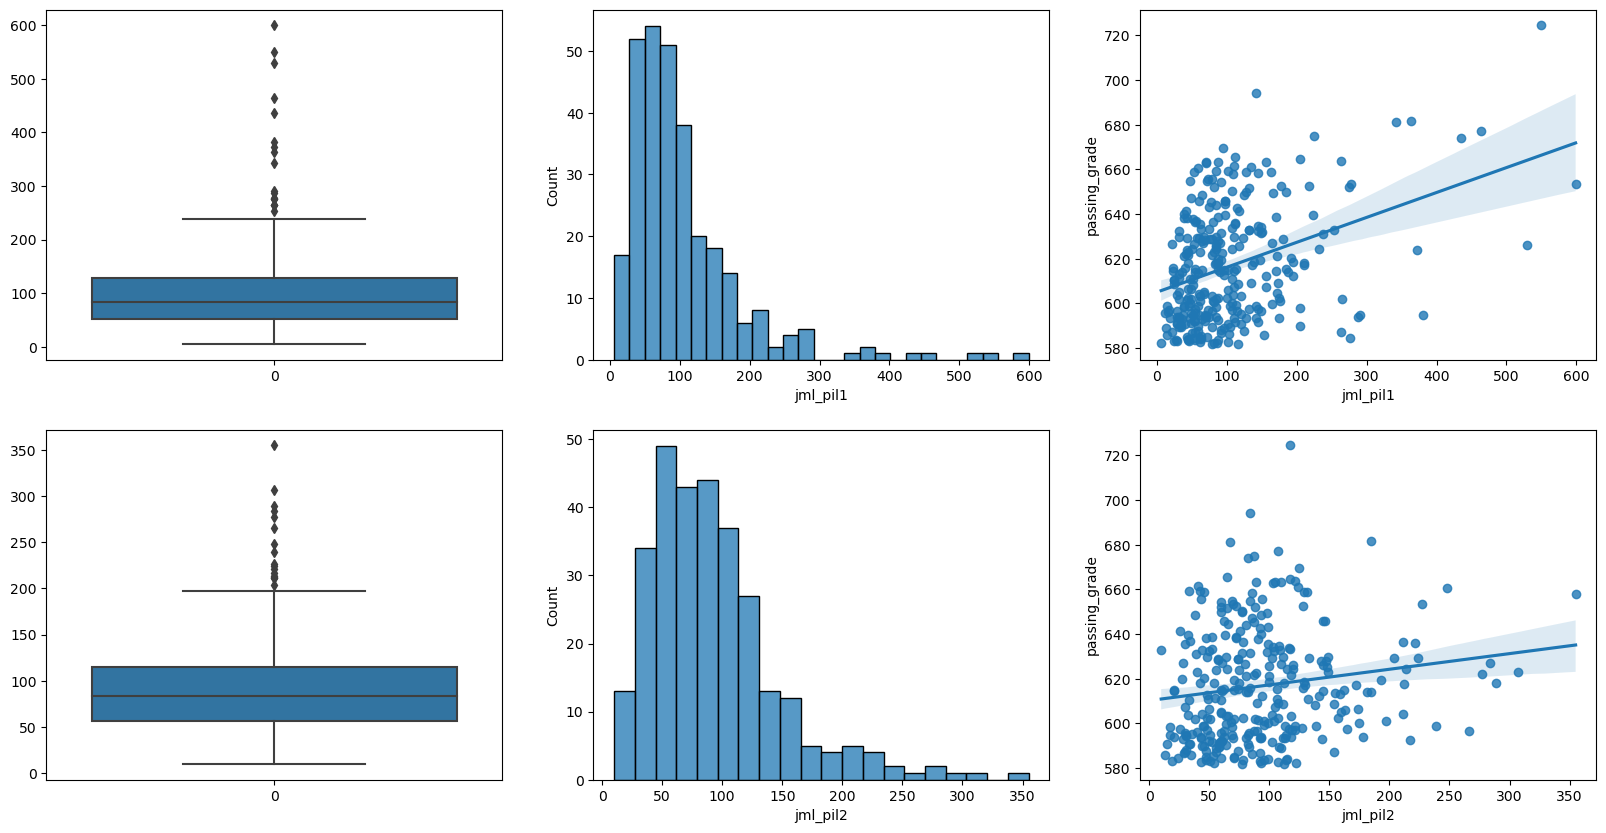

In [40]:
cols = [col for col in df_train_fix.columns if col.startswith('jml') and col != 'passing_grade']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
for i in range(2):
    sns.boxplot(df_train_fix[cols[i]], ax=axs[i,0])
    sns.histplot(df_train_fix[cols[i]], ax=axs[i,1])
    sns.regplot(x=cols[i], y='passing_grade', data=df_train_fix, ax=axs[i,2])
plt.show()

melihat korelasi antar fitur menggunakan heatmap

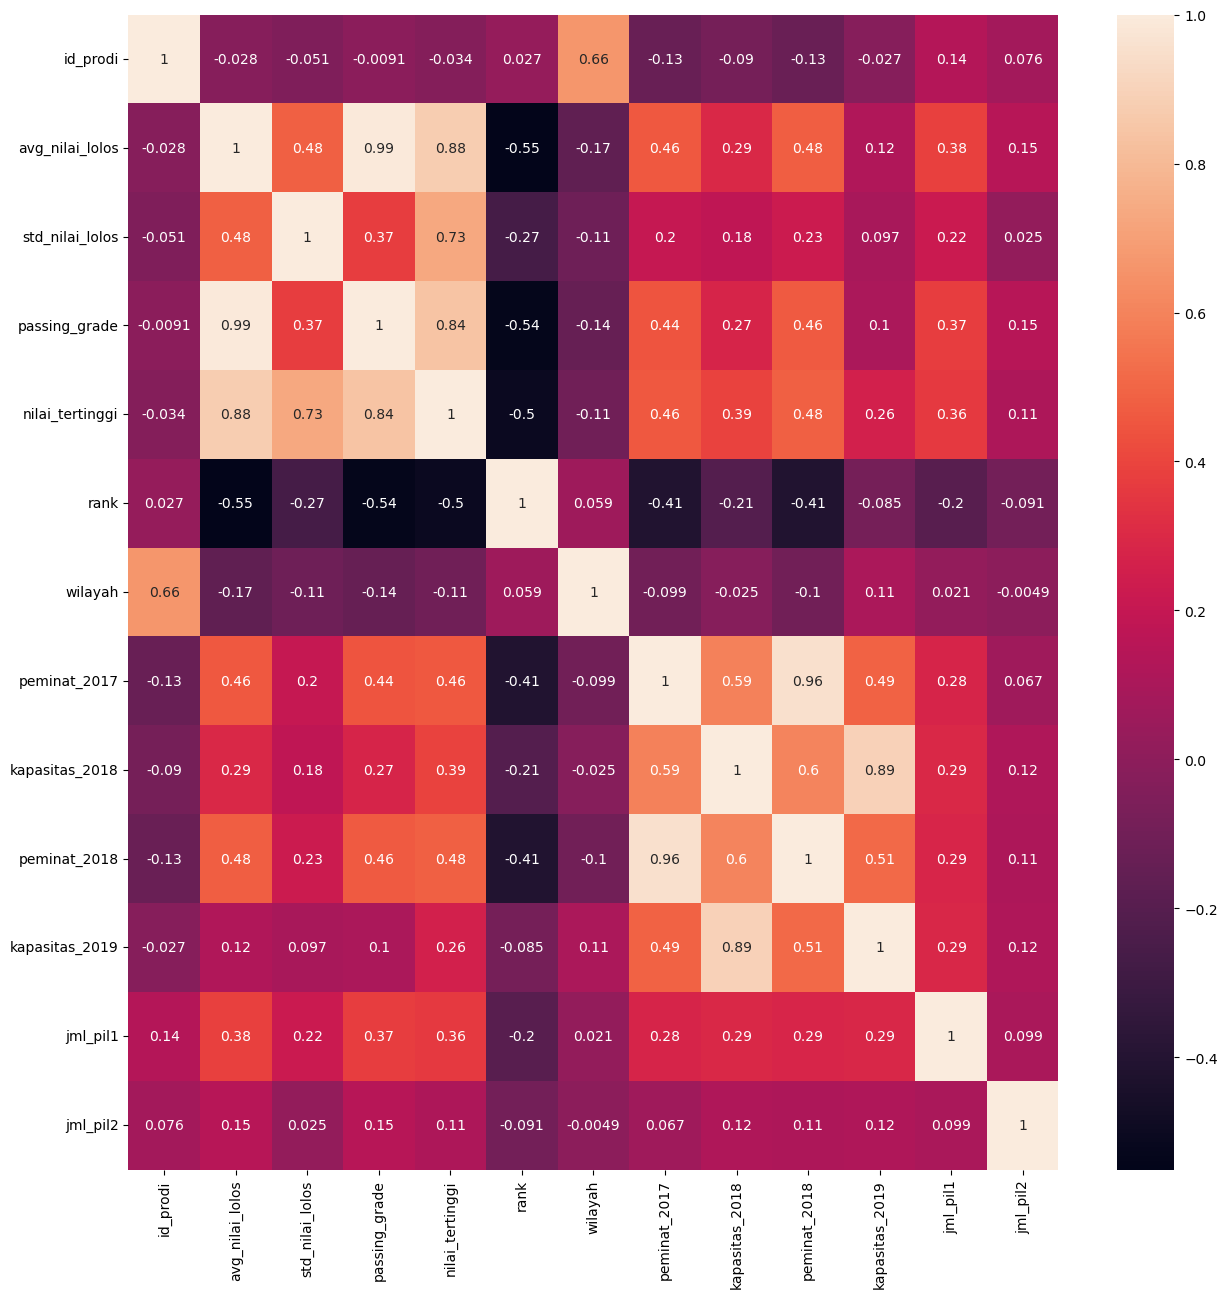

In [41]:
xy = df_train_fix.copy()
plt.figure(figsize=(15,15))
sns.heatmap(xy[xy.columns].corr(), annot=True)
plt.show()

In [42]:
# one hot encoding wilayah
ohe = pd.get_dummies(df_train_fix['wilayah'].astype(int), prefix='wilayah')
df_train_fix[ohe.columns] = ohe
df_train_fix = df_train_fix.drop('wilayah', axis=1)

# one hot encoding wilayah
ohe = pd.get_dummies(df_test_fix['wilayah'], prefix='wilayah')
df_test_fix[ohe.columns] = ohe
df_test_fix = df_test_fix.drop('wilayah', axis=1)

In [43]:
# reorder columns in data test
df_test_fix = df_test_fix.reindex(['id_prodi', 'avg_nilai_lolos', 'std_nilai_lolos', 
       'nilai_tertinggi', 'rank', 'peminat_2017', 'kapasitas_2018',
       'peminat_2018', 'kapasitas_2019', 'jml_pil1', 'jml_pil2', 'wilayah_1',
       'wilayah_2', 'wilayah_3', 'wilayah_4'], axis=1)

In [44]:
# drop wilayah karena nilai korelasinya dengan passing_grade rendah
df_train_fix = df_train_fix.drop(['wilayah_1', 'wilayah_2', 'wilayah_3', 'wilayah_4'], axis=1)
df_test_fix = df_test_fix.drop(['wilayah_1', 'wilayah_2', 'wilayah_3', 'wilayah_4'], axis=1)

In [45]:
testing = df_train_fix[['id_prodi', 'avg_nilai_lolos', 'std_nilai_lolos', 'passing_grade','nilai_tertinggi', 'rank','peminat_2017', 'kapasitas_2018','peminat_2018', 'kapasitas_2019','jml_pil1', 'jml_pil2']].copy()

In [46]:
# list kolom untuk scaling
to_scale = ['avg_nilai_lolos', 'std_nilai_lolos','nilai_tertinggi','peminat_2017', 'kapasitas_2018', 'peminat_2018','kapasitas_2019', 'jml_pil1', 'jml_pil2']

In [47]:
df_test_fix.head()

,id_prodi,avg_nilai_lolos,std_nilai_lolos,nilai_tertinggi,rank,peminat_2017,kapasitas_2018,peminat_2018,kapasitas_2019,jml_pil1,jml_pil2
0,3621103,627.546875,25.233601,707.000,506.0,871.0,34.0,837.0,32,68.0,48.0
1,3211151,630.135417,17.079987,683.250,94.0,1169.0,60.0,1113.0,48,58.0,91.0
2,1711326,591.447917,27.397085,691.625,428.0,2179.0,49.0,2096.0,60,94.0,62.0
3,3531313,604.175000,15.250815,651.250,611.0,0.0,26.0,774.0,50,57.0,30.0
4,3551267,637.275000,20.190316,698.375,228.0,811.0,33.0,758.0,45,63.0,35.0


In [48]:
# scaling kolom
scaler = StandardScaler()
for i in range(len(testing.columns)):
    col = testing.columns[i]
    if col in to_scale:
        scaled = scaler.fit_transform(np.array(testing[col]).reshape(-1, 1))
        testing[col] = scaled

In [49]:
predictors = [col for col in testing if col != 'passing_grade']
target = 'passing_grade'

# split data untuk train dan validasi
X_train, X_val, y_train, y_val = train_test_split(testing[predictors], testing[target], test_size=0.2, random_state=101)

# Modelling

In [50]:
train_dataset = catboost.Pool(X_train, y_train) 
test_dataset = catboost.Pool(X_val, y_val)

In [51]:
cb = catboost.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.01, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

cb.grid_search(grid, train_dataset)

0:	learn: 610.8215832	test: 613.3178843	best: 613.3178843 (0)	total: 58.1ms	remaining: 5.75s
1:	learn: 604.7472972	test: 607.2409069	best: 607.2409069 (1)	total: 58.9ms	remaining: 2.89s
2:	learn: 598.7319605	test: 601.2020481	best: 601.2020481 (2)	total: 59.6ms	remaining: 1.93s
3:	learn: 592.7779712	test: 595.2686619	best: 595.2686619 (3)	total: 60.1ms	remaining: 1.44s
4:	learn: 586.8825302	test: 589.3746990	best: 589.3746990 (4)	total: 60.5ms	remaining: 1.15s
5:	learn: 581.0471505	test: 583.5675278	best: 583.5675278 (5)	total: 60.9ms	remaining: 954ms
6:	learn: 575.2661797	test: 577.8018409	best: 577.8018409 (6)	total: 61.3ms	remaining: 815ms
7:	learn: 569.5411873	test: 572.0675467	best: 572.0675467 (7)	total: 61.6ms	remaining: 709ms
8:	learn: 563.8702897	test: 566.4050183	best: 566.4050183 (8)	total: 62ms	remaining: 627ms
9:	learn: 558.2580773	test: 560.7973062	best: 560.7973062 (9)	total: 62.3ms	remaining: 561ms
10:	learn: 552.7074631	test: 555.2593048	best: 555.2593048 (10)	total: 6

{'params': {'depth': 2,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

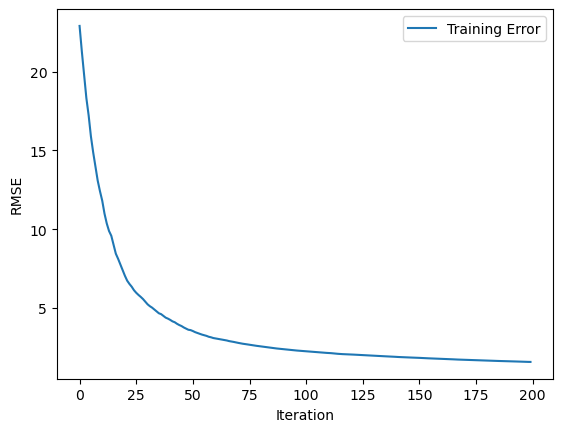

In [52]:
train_error = []
valid_error = []
for score in cb.evals_result_['learn']['RMSE']:
    train_error.append(score)

# Plot the training and validation error during grid search
plt.plot(train_error, label='Training Error')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [53]:
y_pred_cb = cb.predict(X_val)
mae = mean_absolute_error(y_val, y_pred_cb)
mape = mean_absolute_percentage_error(y_val, y_pred_cb)
mse = mean_squared_error(y_val, y_pred_cb)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_cb)

print('Testing performance')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

Testing performance
MAE: 2.6822447076213356
MAPE: 0.004186782371174734
MSE: 37.068139184619376
RMSE: 6.08836096044078
R2: 0.9526732461866162


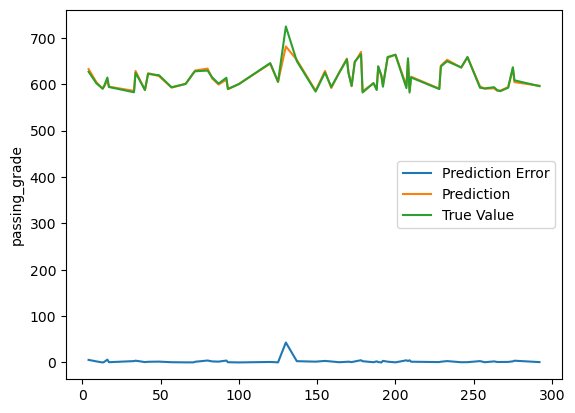

In [54]:
# visualisasi hasil prediction pada data validation
pred_error = abs(y_pred_cb - y_val)

hasil = pd.DataFrame({'prediction':y_pred_cb, 'true_value': y_val, 'prediction_error': pred_error})
plt.ylabel('passing_grade')
sns.lineplot(x=hasil.index, y='prediction_error', data=hasil, label='Prediction Error')
sns.lineplot(x=hasil.index, y='prediction', data=hasil, label='Prediction')
sns.lineplot(x=hasil.index, y='true_value', data=hasil, label='True Value')
plt.show()

In [55]:
maks = hasil['prediction_error'].max()
hasil.loc[hasil['prediction_error']==maks, :]

# kolom dengan prediction error paling tinggi
testing.iloc[130]

id_prodi           3.721383e+06
avg_nilai_lolos   -7.976388e-01
std_nilai_lolos   -1.240584e+00
passing_grade      5.987700e+02
nilai_tertinggi   -1.349785e+00
rank               6.480000e+02
peminat_2017      -1.166099e+00
kapasitas_2018    -5.878226e-01
peminat_2018      -1.228974e+00
kapasitas_2019    -5.540705e-01
jml_pil1          -7.860904e-01
jml_pil2           5.112825e-01
Name: 132, dtype: float64

# Submission

In [56]:
testing2 = df_test_fix[['id_prodi', 'avg_nilai_lolos', 'std_nilai_lolos','nilai_tertinggi', 'rank','peminat_2017', 'kapasitas_2018','peminat_2018', 'kapasitas_2019','jml_pil1', 'jml_pil2']].copy()

scaling data test

In [57]:
scaler = StandardScaler()
for i in range(len(testing2.columns)):
    col = testing2.columns[i]
    if col in to_scale:
        scaled = scaler.fit_transform(np.array(testing2[col]).reshape(-1, 1))
        testing2[col] = scaled

create prediction

In [58]:
data_test = testing2.copy()
y_result = cb.predict(data_test)

In [59]:
data_test = testing2.copy()
y_result = cb.predict(data_test)

In [60]:
result.to_csv('submission.csv', index=False)

In [61]:
result

,id_prodi,passing_grade
0,3621103,611.539041
1,3211151,619.262548
2,1711326,582.005675
3,3531313,597.497698
4,3551267,618.140094
...,...,...
195,3821225,614.054805
196,3221033,599.015818
197,3211062,636.652146
198,3341085,598.349449
